**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

**We do not need to output the actual probability values when performing classification with the softmax layer. Softmax layer transforms the output into a probability distribution, not necessarily the true probability distribution. There are other ways to obtain a probability distribution from a layer output but the nice property of softmax with crossentropy loss is that it makes the gradient calculation so easy: a simple subtracting is enough. By using softmax, what we try to obtain is not the real distribution but a ranking among the class labels and how certain the class is.**

**Also, the classification does not require the outputs to be in a specific range. For example, consider a binary classification problem and let us use a linear activation function in the last layer. This does not constraint the range of the network outputs. However, we can pick a threshold over which we classify the input as the positive class (or the negative one). However, the model is actually a regression model and the training of the network be harder. Also, for multi-class classification, the range of outputs now matter since we pick thresholds on our own and we do not know what should be these thresholds. We might not even have an ordinal relationship between the classes which makes determining the threshold harder. Thus, limiting the sum of the network outputs, like softmax makes the sum equal to 1, makes the training and inference easier and more consistent.**

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

**Overfitting is the situation where the model learns the noise in the training data rather than the important patterns, which allows the model to generalize to unseen samples. Therefore, an indication is overfitting is a large gap between the training and validation performances. If a model overfits, the training performance is much better than the validation performance. Thus, train/validation losses vs epoch plots might be useful to monitor overfitting. Underfitting is the situation where the model complexity is not sufficient to capture the complex patterns in data. Again, the train/validation losses vs epoch plot might be useful to observe whether the model can learn, i.e., whether the loss drops.**

c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

**Stacking linear layers only allows the model to capture linear patterns between the inputs since taking multiple linear combinations of an input still results in a linear combination. ReLU (or any nonlinear activation function) allows the model to capture nonlinear relationships among the inputs. There is a strong result called universal approximation theorem which proves that the fully-connected neural networks with ReLU activation function can represent any function under some constraints.**

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

**The layer has $((3 \times 3 \times 5) + 1) * 6 = 276$ learnable parameters. (((filter_width $\times$ filter_height $\times$ the number of channels in the previous layer) + 1) $\times$ the number of filters) gives the number of learnable parameters, where the additional 1 comes from the bias terms.**

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [ ]:
from collections import defaultdict
from itertools import product
from pathlib import Path
import os 
import time
import random

from tabulate import tabulate
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchmetrics
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1060 6GB
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     6.0 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [ ]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [ ]:
PROJECT_ROOT_DIR = Path().resolve()
DATASET_DIR = PROJECT_ROOT_DIR / 'dataset'
MODELS_DIR = PROJECT_ROOT_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.images = ImageFolder(self.path, transform=self.transform)

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.images)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        return self.images[index]

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
def load_datasets(path, transform, val_ratio=0.1, test_ratio=0.2):
    dataset = CustomDataset(None, None, path=path, transform=transform)
    cardinality = len(dataset)
    val_dataset_cardinality = int(cardinality * val_ratio)
    test_dataset_cardinality = int(cardinality * test_ratio)
    train_dataset_cardinality = cardinality - val_dataset_cardinality - test_dataset_cardinality
    return random_split(dataset, [train_dataset_cardinality, val_dataset_cardinality, test_dataset_cardinality])

In [ ]:
train_dataset, val_dataset, test_dataset = load_datasets(DATASET_DIR, transform)

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [ ]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(50176, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=-1)
        )
     
    def forward(self, x):
        return self.network(x)

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224 * 224 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Softmax(dim=-1)
        )
     
    def forward(self, x):
        return self.network(x.to(device))

## Helper functions

In [ ]:
labels = [label.stem for label in DATASET_DIR.iterdir()]

In [ ]:
def plot_loss_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(len(history['train_loss'])), 
             [val.cpu().detach().numpy() for val in history['train_loss']], 
             label='Train loss')
    ax2.plot(range(len(history['valid_loss'])), 
             [val.cpu().detach().numpy() for val in history['valid_loss']], 
             label='Valid loss')
    
    ax1.set_title(f'Train Loss vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Values')
    
    ax2.set_title(f'Valid Loss vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Values')
    
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(len(history['train_accuracy'])), 
             [val.cpu().detach().numpy() for val in history['train_accuracy']], 
             label='Train accuracy')
    ax2.plot(range(len(history['valid_accuracy'])), 
             [val.cpu().detach().numpy() for val in history['valid_accuracy']], 
             label='Valid accuracy')
    
    ax1.set_title(f'Train Accuracy vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Values')
    
    ax2.set_title(f'Valid Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Values')
    
    plt.legend()
    plt.show()

In [ ]:
def get_best_model(model_cls, model_cls_name):
    model_states = [state for state in MODELS_DIR.iterdir() if state.name.startswith(f'model-{model_cls_name}')]
    model_losses = [float(state.name[-6:]) for state in model_states]
    best_model_index = np.argmin(model_losses)
    model = model_cls()
    state_dict = torch.load(model_states[best_model_index])
    model.load_state_dict(state_dict())
    model.eval()
    return model

In [ ]:
def plot_confusion_matrix(cm):
    ConfusionMatrixDisplay(cm.cpu().detach().numpy(), display_labels=labels).plot()

In [ ]:
def show_results(loss, acc, precision, recall, f1):
    table = [
        ['Loss', loss],
        ['Accuracy', acc],
        ['Precision', precision],
        ['Recall', recall],
        ['F1', f1]
    ]
    print(tabulate(table, headers=['Metric', 'Score'], tablefmt='fancy_grid'))

In [ ]:
@torch.no_grad()
def evaluate(model, dataset):
    model.eval()
    dataset_loader = DataLoader(dataset, batch_size=len(dataset))
    accuracy_score = torchmetrics.Accuracy(task='multiclass', average='macro', num_classes=4).to(device)
    precision_score = torchmetrics.Precision(task='multiclass', average='macro', num_classes=4).to(device)
    recall_score = torchmetrics.Recall(task='multiclass', average='macro', num_classes=4).to(device)
    f1_score = torchmetrics.F1Score(task='multiclass', average='macro', num_classes=4).to(device)
    confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', average='macro', num_classes=4).to(device)
    
    test_outputs = [model(im.to(device)) for im, _ in dataset_loader]
    loss = torch.stack([F.cross_entropy(outputs.to(device), labels.to(device)) 
                        for outputs, (_, labels) in zip(test_outputs, dataset_loader)]).mean()
    accuracy = torch.stack([accuracy_score(outputs.to(device), labels.to(device)) 
                            for outputs, (_, labels) in zip(test_outputs, dataset_loader)]).mean()
    precision = torch.stack([precision_score(outputs.to(device), labels.to(device)) 
                             for outputs, (_, labels) in zip(test_outputs, dataset_loader)]).mean()
    recall = torch.stack([recall_score(outputs.to(device), labels.to(device)) 
                          for outputs, (_, labels) in zip(test_outputs, dataset_loader)]).mean()
    f1 = torch.stack([f1_score(outputs.to(device), labels.to(device)) 
                      for outputs, (_, labels) in zip(test_outputs, dataset_loader)]).mean()
    cm = torch.stack([confusion_matrix(outputs.to(device), labels.to(device)) 
                      for outputs, (_, labels) in zip(test_outputs, dataset_loader)])
    return loss, accuracy, precision, recall, f1, cm[0]

In [ ]:
@torch.no_grad()
def validation(model, dataset_loader):
    model.eval()
    accuracy_score = torchmetrics.Accuracy(task='multiclass', num_classes=4).to(device)
    valid_outputs = [model(im.to(device)) for im, _ in dataset_loader]
    valid_loss = torch.stack([F.cross_entropy(outputs.to(device), labels.to(device)) 
                              for outputs, (_, labels) in zip(valid_outputs, dataset_loader)]).mean()
    valid_acc = torch.stack([accuracy_score(outputs.to(device), labels.to(device)) 
                             for outputs, (_, labels) in zip(valid_outputs, dataset_loader)]).mean()
    return valid_loss, valid_acc

In [ ]:
def train(model_cls,
          model_cls_name,
          epochs,
          train_batch_size,
          test_batch_size,
          learning_rate,
          momentum,
          weight_decay,
          train_dataset,
          validation_dataset,
          optimizer_cls=torch.optim.SGD):
    torch.cuda.empty_cache()
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size)
    val_loader = DataLoader(dataset=validation_dataset, batch_size=test_batch_size)
    
    model = model_cls().to(device)
    optimizer = optimizer_cls(model.parameters(), learning_rate, momentum=momentum, weight_decay=weight_decay)
    history = defaultdict(list)
    
    accuracy_score = torchmetrics.Accuracy(task='multiclass', num_classes=4).to(device)
    min_val_loss = np.inf
    for epoch in range(epochs):
        batch_losses = []
        batch_accuracies = []
        for i, batch in (progress_bar := tqdm(enumerate(train_loader), total=len(train_loader))):
            im, labels = batch
            im = im.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(im)

            loss = F.cross_entropy(outputs, labels)
            accuracy = accuracy_score(outputs, labels)

            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

            loss.backward()
            optimizer.step()
            
            progress_bar.set_description_str(f'Epoch: {epoch + 1}/{epochs}')
            progress_bar.set_postfix_str(f'train_loss={batch_losses[-1]:.4f}, '
                                         f'train_accuracy={batch_accuracies[-1]:.2f}')
            
            if i == len(train_loader) - 1:
                history['train_loss'].append(torch.stack(batch_losses).mean())
                history['train_accuracy'].append(torch.stack(batch_accuracies).mean())

                valid_loss, valid_accuracy = validation(model, val_loader)
                history['valid_loss'].append(valid_loss)
                history['valid_accuracy'].append(valid_accuracy)
                
                if valid_loss <= min_val_loss:
                    torch.save(model.state_dict, MODELS_DIR / f'model-{model_cls_name}-acc={valid_accuracy:.2f}-loss={valid_loss:.4f}')
                    min_val_loss = valid_loss
                
                progress_bar.set_postfix_str(f'train_loss={history["train_loss"][-1]:.4f}, '
                                             f'train_acc={history["train_accuracy"][-1]:.2f}, '
                                             f'val_loss={history["valid_loss"][-1]:.4f}, '
                                             f'val_acc={history["valid_accuracy"][-1]:.2f}')
    return history

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

**The validation loss measures the model's certainty about its prediction, whereas any metric using predictions rather than probabilities do not take the certainty of the model into account. Thus, I prefer validation loss over other metrics such as accuracy and f1 score.**

### Training [12 points]

In [ ]:
#Pick your hyper parameters
max_epoch = 30
train_batch = 64
test_batch = 64
learning_rate = 1e-3
momentum = 0.95
weight_decay = 1e-4

history = train(FCNet, 'fcn', max_epoch, train_batch, test_batch, learning_rate,
                momentum, weight_decay, train_dataset, val_dataset)

Epoch: 30/30: 100%|██| 13/13 [00:11<00:00,  1.18it/s, train_loss=0.9147, train_acc=0.85, val_loss=0.9205, val_acc=0.85]


### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

**Please check the "Helper functions" subsection above. the plotting script is implemented there.**

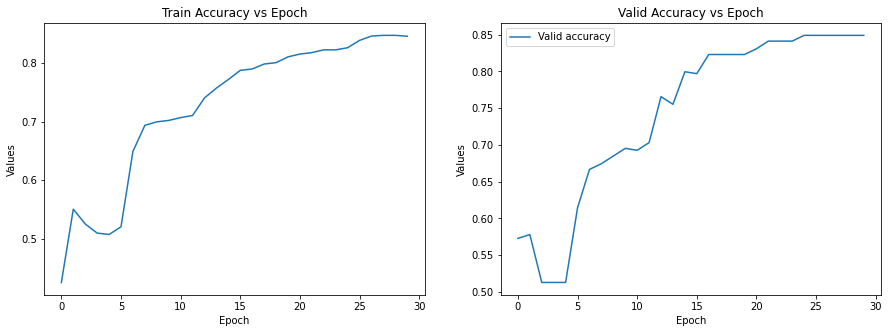

In [ ]:
plot_accuracy_curves(history)

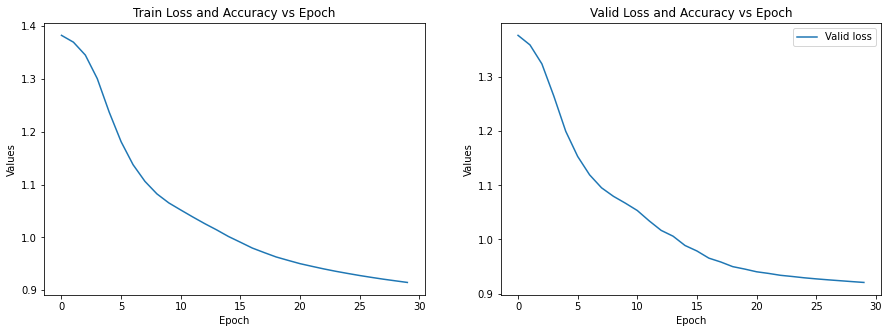

In [ ]:
plot_loss_curves(history)

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

**Please check the "Helper functions" subsection above. The evaluation script is implemented there.**

In [ ]:
best_model = get_best_model(FCNet, 'fcn').to(device)

In [ ]:
loss, accuracy, precision, recall, f1, cm = evaluate(best_model, test_dataset)

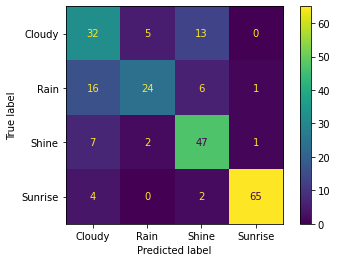

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
show_results(loss, accuracy, precision, recall, f1)

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Loss      │ 0.986686 │
├───────────┼──────────┤
│ Accuracy  │ 0.722673 │
├───────────┼──────────┤
│ Precision │ 0.744473 │
├───────────┼──────────┤
│ Recall    │ 0.722673 │
├───────────┼──────────┤
│ F1        │ 0.724142 │
╘═══════════╧══════════╛


## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

**The validation loss measures the model's certainty about its prediction, whereas any metric using predictions rather than probabilities do not take the certainty of the model into account. Thus, I prefer validation loss over other metrics such as accuracy and f1 score.**

### Training [12 points]

In [ ]:
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 3e-2
momentum = 0.75
weight_decay = 1e-4

history = train(ConvNet, 'cnn', max_epoch, train_batch, test_batch, learning_rate,
                momentum, weight_decay, train_dataset, val_dataset)

Epoch: 99/100: 100%|█| 13/13 [00:08<00:00,  1.57it/s, train_loss=0.7996, train_acc=0.94, val_loss=0.9417, val_acc=0.79]
Epoch: 100/100: 100%|█| 13/13 [00:09<00:00,  1.44it/s, train_loss=0.8069, train_acc=0.94, val_loss=0.8801, val_acc=0.86


### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

**Please check the "Helper functions" subsection above. the plotting script is implemented there.**

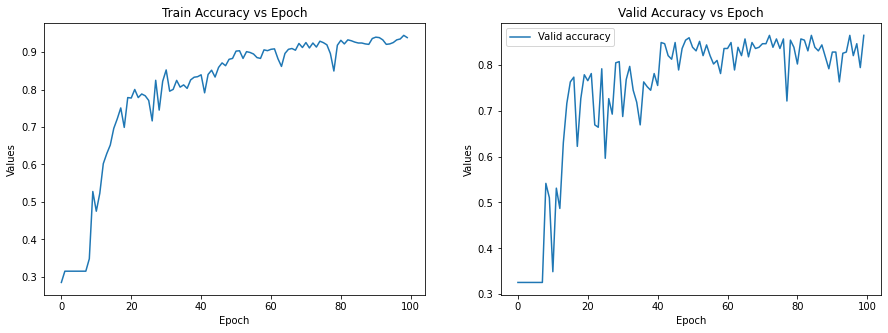

In [ ]:
plot_accuracy_curves(history)

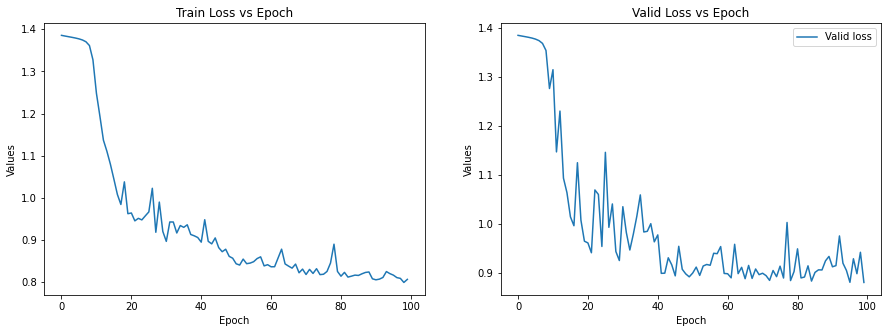

In [ ]:
plot_loss_curves(history)

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

**Please check the "Helper functions" subsection above. The evaluation script is implemented there.**

In [ ]:
best_model = get_best_model(ConvNet, 'cnn').to(device)

In [ ]:
loss, accuracy, precision, recall, f1, cm = evaluate(best_model, test_dataset)

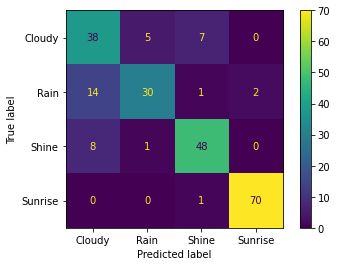

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
show_results(loss, accuracy, precision, recall, f1)

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Loss      │ 0.910282 │
├───────────┼──────────┤
│ Accuracy  │ 0.80658  │
├───────────┼──────────┤
│ Precision │ 0.820249 │
├───────────┼──────────┤
│ Recall    │ 0.80658  │
├───────────┼──────────┤
│ F1        │ 0.808732 │
╘═══════════╧══════════╛


### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

In [ ]:
total_params_fc = sum(p.numel() for p in FCNet().parameters())
print('Total number of parameters in the fully connected model:', total_params_fc)

Total number of parameters in the fully connected model: 154798852


In [ ]:
total_params_cnn = sum(p.numel() for p in ConvNet().parameters())
print('Total number of parameters in the CNN model:', total_params_cnn)

Total number of parameters in the CNN model: 52061988


In [ ]:
print(f'The fully connected network has {total_params_fc - total_params_cnn} parameters more than the CNN despite the layer counts.')

The fully connected network has 102736864 parameters more than the CNN despite the layer counts.


**CNNs are really efficient in parameter count since their weights are tied. The number of parameters in a CNN layer is proportional to the kernel size, which are inherently much smaller than the image sizes, whereas the number of parameters in a fully connected layer is proportional to the image size. Therefore, CNNs have less parameters even though with more layers as in this case. CNNs makes the locality assumption; that the information of a pixel is mostly about the pixels nearby. Though this assumption might not hold for some images, CNNs still perform very well since stacking convolutional layers increases the perceptive field of the deeper convolutional neurons. In a deep CNN, a neuron in deeper layers can process information from all the image even though the kernel size is much smaller than the original image.**

**In the experiments, we see that the CNN plots oscillates too much. It needs more hyperparameter tuning and more regularization since the training loss is much lower than the validation loss. We observe that CNN outperforms the fully connected network on the test set despite the lower number of weights.**

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

**The validation loss measures the model's certainty about its prediction, whereas any metric using predictions rather than probabilities do not take the certainty of the model into account. Thus, I prefer validation loss over other metrics such as accuracy and f1 score.**

### Training [12 points]

In [ ]:
def load_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 4)
    return model

In [ ]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 6e-3
weight_decay = 2e-04

# TODO: Implement training loop + eval using ResNet-18 model
history = train(load_resnet18, 'resnet', max_epoch, train_batch, test_batch, learning_rate,
                momentum, weight_decay, train_dataset, val_dataset)

Epoch: 10/10: 100%|██| 13/13 [00:07<00:00,  1.63it/s, train_loss=0.1565, train_acc=0.98, val_loss=0.1933, val_acc=0.96]


### Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

**Please check the "Helper functions" subsection above. the plotting script is implemented there.**

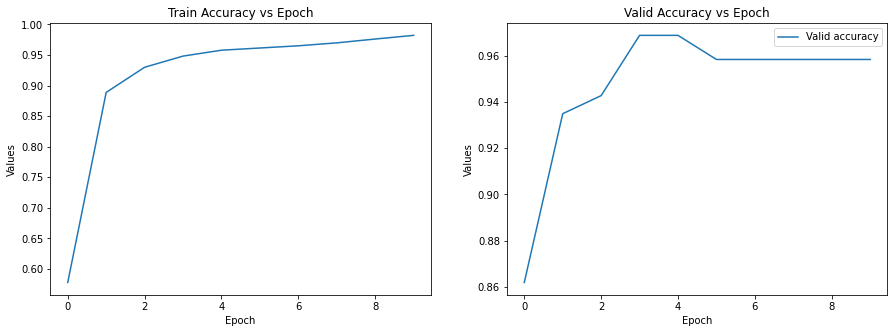

In [ ]:
plot_accuracy_curves(history)

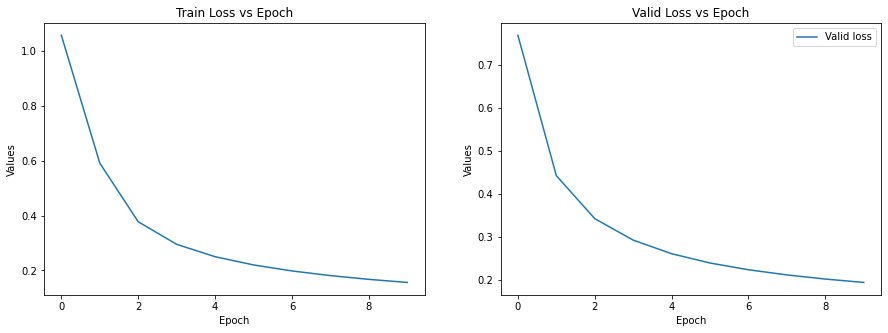

In [ ]:
plot_loss_curves(history)

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

**Please check the "Helper functions" subsection above. The evaluation script is implemented there.**

In [ ]:
best_model = get_best_model(load_resnet18, 'resnet').to(device)

In [ ]:
loss, accuracy, precision, recall, f1, cm = evaluate(best_model, test_dataset)

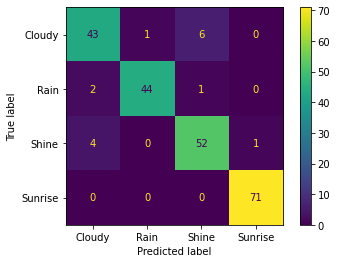

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
show_results(loss, accuracy, precision, recall, f1)

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Loss      │ 0.210006 │
├───────────┼──────────┤
│ Accuracy  │ 0.927113 │
├───────────┼──────────┤
│ Precision │ 0.930699 │
├───────────┼──────────┤
│ Recall    │ 0.927113 │
├───────────┼──────────┤
│ F1        │ 0.928692 │
╘═══════════╧══════════╛


### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

**The convolutional layers extract features from the images. Transfer learning assumes that the extracted features for a task also work for other tasks. Here, we transferred the weights trained on the ImageNet dataset and used those weights on our tasks. We can see that the extracted features works well for this task and the model outperforms the other two models.**

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1